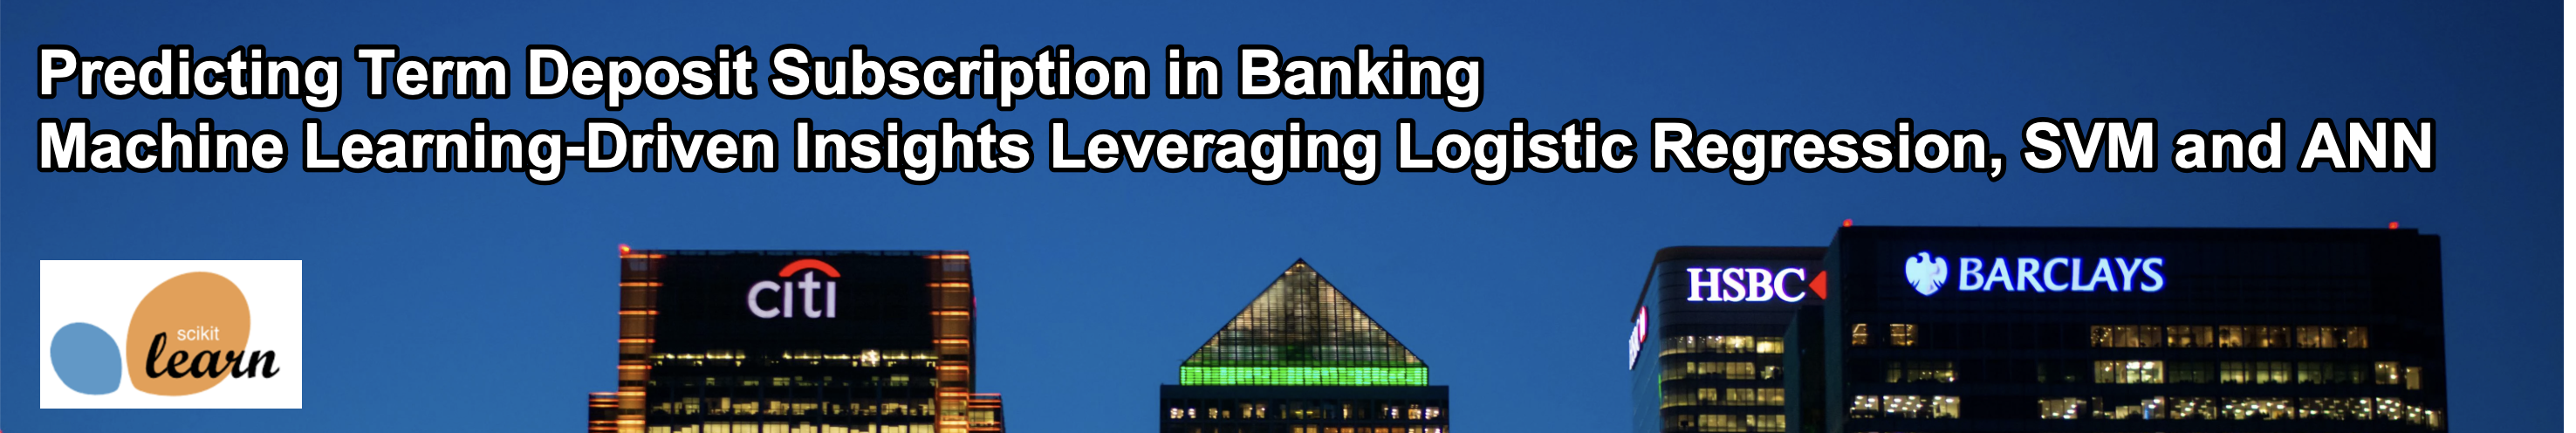

## Part 1: Logistic Regression 

We are given a dataset of  direct marketing campaigns of a credit institution. **Our goal is to implement a model to predict whether the client will subscribe to a term deposit.**

DATASET DESCRIPTION

- age (numeric)
- job : type of job 
- marital : marital status
- education 
- default: has credit in default? 
- housing: has housing loan? 
- loan: has personal loan? 
- contact: contact communication type 
- month: last contact month of year 
- day_of_week: last contact day of the week 
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
- campaign: number of contacts performed during this campaign and for this client 
- pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign 
- emp.var.rate: employment variation rate 
- cons.price.idx: consumer price index 
- cons.conf.idx: consumer confidence index 
- euribor3m: euribor 3 month rate 
- nr.employed: number of employees 
- y — Target variable: has the client subscribed a term deposit? 

##### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=18)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('banking.csv')
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


In [4]:
data.shape

(41188, 21)

## EDA and Feature Engineering 

An important requirement for Logistic Regression to function properly is Feature Engineering as it helps to identify independent variables. Without proper identification of independent variables Logistic Regression fails to perform correctly.

One disadvantage of logistic regression is that it doesn’t handle large number of categorical variables well.

```education``` column has many categories, try to reduce the categories for a better modelling. The education column has the following categories.


In [7]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

We will group all ```basic.XX``` in a unique value ```basic```

In [9]:
data['education'] = data['education'].apply(lambda x: 'basic' if x.startswith('basic') else x)
data['education']

0                      basic
1                    unknown
2          university.degree
3                high.school
4                      basic
                ...         
41183            high.school
41184                  basic
41185      university.degree
41186    professional.course
41187            high.school
Name: education, Length: 41188, dtype: object

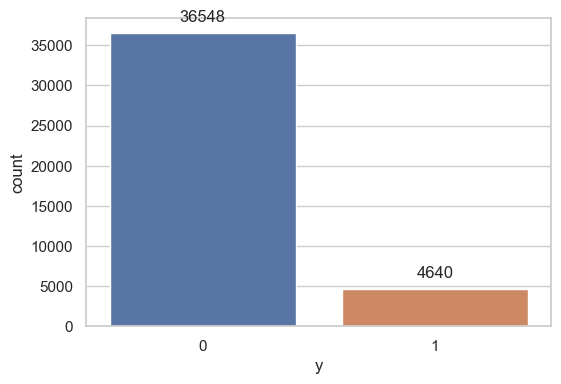

In [10]:
# 1. Get the counts of the target variable
target_count = data['y'].value_counts()

# Convert index to string for proper labeling
target_index = target_count.index.astype(str)
target_values = target_count.values

# 2. Create a figure
plt.figure(figsize=(6, 4))

# 3. Plot the bar chart
ax = sns.barplot(x=target_index, y=target_values, hue=target_index)

# 4. Set axis labels
ax.set_xlabel("y")
ax.set_ylabel("count")

# 5. Annotate each bar with its exact count
for i, v in enumerate(target_values):
    ax.text(i, v + 1400, str(v), ha='center')

# 6. Show the plot
plt.show()

##### Analyse the distribution of the target variable

In [12]:
target_df = target_count.reset_index()
target_df.columns = ['y', 'count']
target_df['perc'] = target_df['count'] / target_df['count'].sum() * 100

# Formatting the percentage to two decimals
target_df['perc'] = target_df['perc'].round(2)
target_df

,y,count,perc
0,0,36548,88.73
1,1,4640,11.27


##### What can we observe about the distribution of the target variable

The majority of clients in this dataset belong to the “0” class, which means they did not subscribe to a term deposit. This clients account for 88.73% of all observations. The “1” class (those who did subscribe) makes up only 11.27% of the data. This indicates a clear class imbalance, where the “no” (0) outcome substantially outnumbers the “yes” (1) outcome.

##### Observe how the different numeric variables behave for the 2 classes

In [16]:
numeric_vars = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Group by target variable 'y' and compute the mean for the numeric variables
grouped_stats = data.groupby('y')[numeric_vars].mean()
grouped_stats

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:
-
- Subscribers to term deposits are slightly older on average
- Subscribers have much longer calls which suggests higher engagement
- In campaigns we have fewer contacts for subscribers which may indicate more targeted efforts
- Subscribers were contacted more recently in previous campaigns (792 vs. 984).
- Previous: Subscribers had more prior contacts (0.49 vs. 0.13), implying repeated touchpoints may help.
- The employment variation rate is a cyclical employment variation which is the variation of how many people are being hired or fired due to the shifts in the conditions of the economy. Based on the data result the emp_var_rate is negative for subscribers (-1.23) vs. positive for non-subscribers (0.25), possibly reflecting macroeconomic timing.
- The Consumer Price Index measures the inflation as experienced by people in their day-to-day life. The consumer price index is slightly higher for subscribers
- The consumer confidence index is slightly less negative for subscribers, indicating higher consumer confidence.
- Euribor means Euro Interbank Offered Rate. The Euribor rates are based on the interest rates at which a panel of European banks borrow funds from one another. Its lower for subscribers (2.12 vs. 3.81), suggesting an economic climate favoring term deposits.

##### Analyse other variables - Make some plots and discuss them

- **Job title**

Text(0, 0.5, 'Frequency of Purchase')


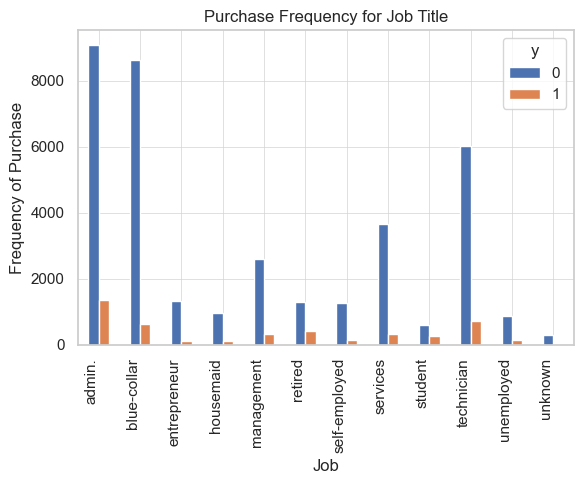

In [20]:
c = data.groupby(['job', 'y']).size().unstack(fill_value=0)
c.plot(kind='bar', figsize=(6, 5))

plt.title("Purchase Frequency for Job Title")
plt.xlabel("Job")
print(plt.ylabel("Frequency of Purchase"))
plt.xticks(rotation=90, ha='right')
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'
plt.tight_layout()
plt.show()

- Targeted volume is not effective: Jobs like admin., blue-collar and technician are frequently contacted but convert poorly
- Retired and students show better subscription ratios. So there should be more alue in focused targeting
- It needs to be explored why certain groupds respond better (e.g. age, financial behaviour)
- **Future campaigns should reallocate effort toward high-conversion segments rather than high-frequency ones**

Text(0, 0.5, 'Frequency of Purchase')


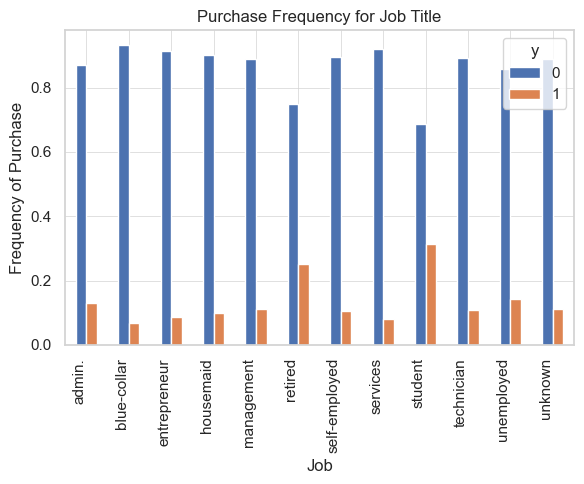

In [22]:
c = data.groupby(['job', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

c.plot(kind='bar', figsize=(6, 5))

plt.title("Purchase Frequency for Job Title")
plt.xlabel("Job")
print(plt.ylabel("Frequency of Purchase"))
plt.xticks(rotation=90, ha='right')
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'
plt.tight_layout()
plt.show()

- Better visualization to cover the conversion rate. Better visible that retired and students convert at higher relative rates.
- Frequent targeting of blue-collar and admin is inefficient because of the low conversion rate
- **Data-driven reallocation of marketing efforts toward high-conversion segments**

- **Marital status**

Text(0, 0.5, 'Proportion of Customers')


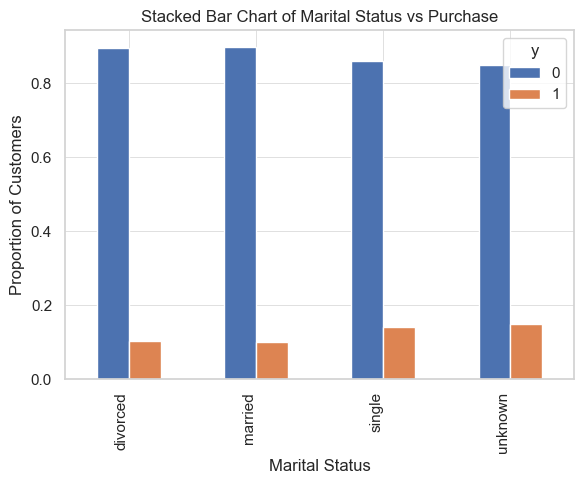

In [25]:
c = data.groupby(['marital', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

ax = c.plot(kind='bar', figsize=(6, 5))

plt.title("Stacked Bar Chart of Marital Status vs Purchase")
plt.xlabel("Marital Status")
print(plt.ylabel("Proportion of Customers"))
plt.xticks(rotation=90, ha='right')

# Grid + styling
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'

plt.legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

- Married and divorced clients exhibit lower conversion rates
- Single and unknown clients show higher responsiveness to term deposits
- **Marital status influences financial behavior and campaign strategies could benefit from segmentation based on relationship status**

- **Education**

Text(0, 0.5, 'Proportion of Customers')


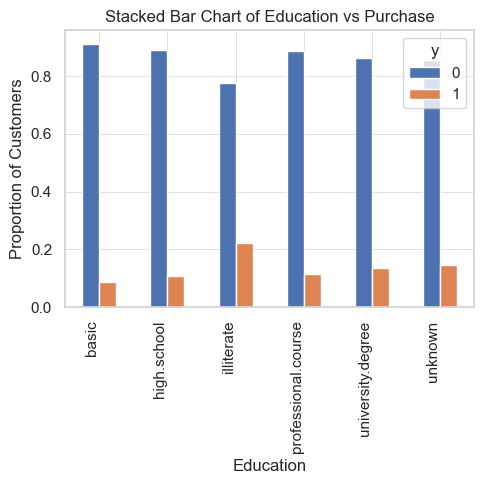

In [28]:
c = data.groupby(['education', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

ax = c.plot(kind='bar', figsize=(5, 5))

plt.title("Stacked Bar Chart of Education vs Purchase")
plt.xlabel("Education")
print(plt.ylabel("Proportion of Customers"))
plt.xticks(rotation=90, ha='right')

# Grid + styling
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'

plt.legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

- Illiterate show strongest relative engagement possibly due to trust in banking advice or fewer financial alternatives
- Basic and high school groups show lowest conversion which may ndicate lower product appeal
- **Education plays a nonlinear role: Lower education doesn’t automatically mean higher subscription rates, but Illiterate should be  targeted due to high conversion**

- **Day of Week**

Text(0, 0.5, 'Frequency of Purchase')


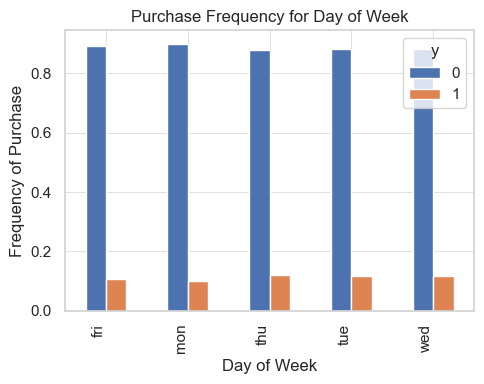

In [31]:
c = data.groupby(['day_of_week', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

ax = c.plot(kind='bar', figsize=(5, 4))

plt.title("Purchase Frequency for Day of Week")
plt.xlabel("Day of Week")
print(plt.ylabel("Frequency of Purchase"))
plt.xticks(rotation=90, ha='right')

# Grid + styling
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'

plt.legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

- Mid-week contact is associated with slightly better subscription rates.
- Monday and Friday shows reduced effectiveness, potentially due to lower client receptiveness or availability.
- **Timing of contact may play a subtle role and could be optimized with Mid-week as part of campaign strategy**

- **Month**

Text(0, 0.5, 'Frequency of Purchase')


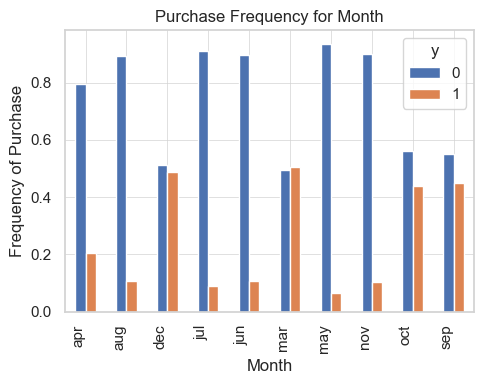

In [34]:
c = data.groupby(['month', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

ax = c.plot(kind='bar', figsize=(5, 4))

plt.title("Purchase Frequency for Month")
plt.xlabel("Month")
print(plt.ylabel("Frequency of Purchase"))
plt.xticks(rotation=90, ha='right')

# Grid + styling
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'

plt.legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

- Best performing months for conversions: March, September, October, December
- Worst conversion months during late spring/summer (May, June, July, August and November)

**Theese trends are critical for campaign planning:**
- **Allocating resources to high-conversion months can significantly improve ROI**
- **Low-performing months may require strategy changes**

- **poutcome**

Text(0, 0.5, 'Frequency of Purchase')


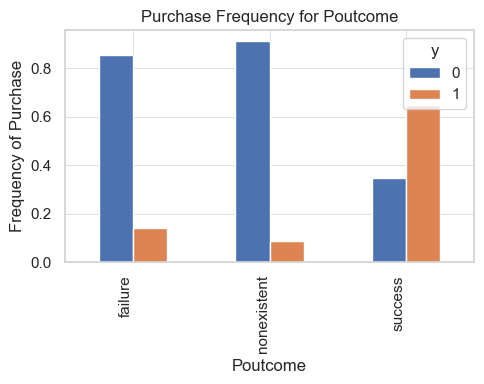

In [37]:
c = data.groupby(['poutcome', 'y']).size().unstack(fill_value=0)
c = c.div(c.sum(axis=1), axis=0)

ax = c.plot(kind='bar', figsize=(5, 4))

plt.title("Purchase Frequency for Poutcome")
plt.xlabel("Poutcome")
print(plt.ylabel("Frequency of Purchase"))
plt.xticks(rotation=90, ha='right')

# Grid + styling
plt.grid(True, axis='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.gca().set_axisbelow(True)
plt.rcParams['axes.edgecolor'] = 'lightgray'

plt.legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

- A successful previous campaign dramatically increases current subscription likelihood which is critical
- Customers with no prior contact or a failed prior attempt are much less likely to subscribe

**Marketing strategies should prioritize leads with successful prior outcomes and retargeting failed ones should be cautiously**

### Create dummy variables

In [40]:
# Drop 'duration' as it's not usable for a predictive model (data leakage)
#data = data.drop('duration', axis=1)

# List of categorical columns to dummy-encode
categorical_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'
]

# Create dummy variables (one-hot encoding), drop first to avoid multicollinearity
data_final = pd.get_dummies(data, columns=categorical_cols) #drop_first=True)

# Optional: Check result
print(data_final.shape)
print(data_final.columns)

(41188, 62)
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_

### Implement the Logistic Regression Model

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

##### Prepare the dataset for training

In [44]:
# Step 1: Define feature matrix and target variable
X = data_final.drop("y", axis=1)
y = data_final["y"]

# Step 2: Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Step 3: Define the model with compatible parameters
model = LogisticRegression(
    C=1.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=100,
    n_jobs=None,
    penalty='l2',
    random_state=None,
    solver='liblinear', # as solver = 'warn' as outdated and 'lbfgs' made issues
    tol=0.0001,
    verbose=0,
    warm_start=False
)

# Step 4: Fit the model
model.fit(X_train, y_train)
print(model)
print(model.get_params())

LogisticRegression(solver='liblinear')
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


##### Compute predictions and accuracy using the accuracy score provided by the sklearn library

In [46]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set: 0.91


##### An accuracy of **91%** looks quite a good result, but have a look more in detail observing the confusion matrix and other metrics you consider interesting.


##### EXPLAIN WHY ACCURACY IS NOT ENOUGH TO EVALUATE THE PERFORMANCE OF A CLASSIFIER AND WHY IT MIGHT FAIL IN CASE OF IMBALANCED DATASET


- **While accuracy of 91% seems impressive, it can be misleading in the context of imbalanced datasets. In our case, the target variable is very skewed. Majority of clients did not subscribe to a term deposit. Models that simply predicts the majority class can still achieve high accuracy without truly learning meaningful patterns.**

- **Accuracy fails to reflect the model’s performance on the minority class**
-  **To properly evaluate the model, it is essential to consider additional metrics such as precision, recall, F1-score, and the confusion matrix. These provide a more detailed view of how well the model distinguishes between classes and whether it is effectively capturing the minority class.**

The confusion matrics gives an interesting overview of how well a model is doing and it is a great starting point for any classification model evaluation.

![](https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg?w=748)

In [50]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[10718   263]
 [  811   565]]


**Is our model obtaining good results or is it failing in some specific case?**

The confusion matrix shows that the model correctly classified 10.718 non-subscribers (True Negatives) and 565 subscribers (True Positives). 
The problem is that it also also made 263 False Positive errors. Clients are predicted whou would subscribe when they wouldnt.

What cna be highlighted also are 811 False Negatives --> which means failing to identify actual subscribers.

While the overall accuracy may appear high, the relatively large number of False Negatives suggests that many potential subscribers are being missed. 

The model is underperforming in identifying the most valuable class particularly in recall for the positive class.

##### Compute other metrics using classification report

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10981
           1       0.68      0.41      0.51      1376

    accuracy                           0.91     12357
   macro avg       0.81      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357



#### Remember:
    
**Precision:** percentage of your results which are relevant. Among all the elements that your model classify as positive, how many are really positive examples?

$\frac{TP}{TP+FP}$
                                            

**Recall:** percentage of total relevant results correctly classified by your algorithm.

$\frac{TP}{TP+FN}$                                            

In [56]:
565/(565+263) #Precision@1

0.6823671497584541

In [57]:
565/(811+565) #Recall@1

0.4106104651162791

## Imbalanced Classes

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.


##### Explain why imbalanced data can be a problem 

**Imbalanced data is a problem because the model learns to favor the majority class and often ignores the minority one — which is usually the one we care about most. It can give you high accuracy, but still fail to detect important cases, like actual subscribers. That’s why accuracy alone becomes misleading, and why metrics like recall and F1-score matter more in these situations.**



##### SMOTE

During the exploratory data analysis we have seen that we have **Imbalanced Classes**, i.e.,the percentage of negative examples is much higher with respect to the percentage of positiv examples. Indeed, observing the confusion matrix we saw that the implmented model face some problem in predict the positive examples (if a client will subscribe a term deposit).


To face this problem we will apply an over-sampling technique trying to balance our dataset generating **Synthetic Samples:** it consists in creating new synthetic points from the minority class to increase its cardinality.

we will use the **SMOTE** Algorithm [see here for more details](https://arxiv.org/pdf/1106.1813.pdf).

In order to apply SMOTE **install the imblearn python library** (if you already have it you do not need to reinstall):

[Follow this instructions](https://imbalanced-learn.readthedocs.io/en/stable/install.html)


### Now implent again the model following all the steps

Prepare the data

In [63]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

##### Apply SMOTE to generate synthetic data

In [65]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

# Create training and test set - test size:30% random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns

# Apply oversampling ONLY ON training data
os_data_X,os_data_y= os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(os_data_X, columns=X_train.columns)
os_data_y= pd.DataFrame(os_data_y, columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


**Notice that we over-sampled only on the training data**

##### Check if the classes in the dataset now are balanced

In [68]:
class_counts = os_data_y['y'].value_counts().reset_index()
class_counts.columns = ['y', 'count']
class_counts['perc'] = (class_counts['count'] / class_counts['count'].sum()) * 100
class_counts['perc'] = class_counts['perc'].round(1)

class_counts

,y,count,perc
0,0,25567,50.0
1,1,25567,50.0


They are prefectly distributed!!

##### Implement the model

In [79]:
# Prepare thedata qith the oversampled dataset
X = os_data_X
y = os_data_y['y']

# Create training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create an instance of the logistic regression model
logreg = LogisticRegression(
    C=1.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=100,
    n_jobs=None,
    penalty='l2',
    random_state=None,
    solver='liblinear', # as solver = 'warn' as outdated and 'lbfgs' made issues
    tol=0.0001,
    verbose=0,
    warm_start=False
)

#Fit the model
logreg.fit(X_train, y_train)
print(logreg)
print(logreg.get_params())

LogisticRegression(solver='liblinear')
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


#### Model Evaluation: evaluate the model and compare with previous implmentation/evaluation

In [83]:
#Compute predictions
y_pred = logreg.predict(X_test)

# score returns the mean accuracy on the given test data and labels.
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


Have a deeper look analysing confusion matrix and classification report

In [86]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the result
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[7427  239]
 [ 545 7130]]


Analysing the confusion matriix we can observe that now our model is able to predict quite weel both positive and negative examples!! Let's see if this is also confirmed looking at precision and recall

In [90]:
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7666
           1       0.97      0.93      0.95      7675

    accuracy                           0.95     15341
   macro avg       0.95      0.95      0.95     15341
weighted avg       0.95      0.95      0.95     15341



The support is the number of occurrences of each class in y_test.


**After applying SMOTE, the model's performance improved significantly — especially in detecting actual subscribers (class 1). Before SMOTE, the model had high accuracy (91%) but poor recall for class 1 (only 41%), meaning it missed most potential customers. This is typical in imbalanced datasets where the model favors the majority class.
SMOTE balanced the training data by generating synthetic examples for the minority class, allowing the model to learn its patterns better. As a result, recall for class 1 jumped to 93%, precision to 97%, and overall F1-score to 0.95. The model now more correctly identifies both classes and performs well across the board
This shows why accuracy alone isn’t enough. SMOTE helped us build a much more balanced and useful model.**

## Part 2: SVM

In [95]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Linear kernel SVM pipeline
svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0, random_state=0))
])

svm_linear.fit(os_data_X, os_data_y.values.ravel())

# Predict on original test set
y_pred_linear = svm_linear.predict(X_test)

# Evaluate
print("Confusion Matrix (SVM_Linear):")
print(confusion_matrix(y_test, y_pred_linear))
print("\nClassification Report (SVM_Linear):")
print(classification_report(y_test, y_pred_linear, digits=2))

Confusion Matrix (SVM_Linear):
[[7489  177]
 [ 677 6998]]

Classification Report (SVM_Linear):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7666
           1       0.98      0.91      0.94      7675

    accuracy                           0.94     15341
   macro avg       0.95      0.94      0.94     15341
weighted avg       0.95      0.94      0.94     15341



In [97]:
# RBF kernel SVM pipeline with tuned parameters
svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma=0.01, random_state=0))
])

svm_rbf.fit(os_data_X, os_data_y.values.ravel())
y_pred_rbf = svm_rbf.predict(X_test)

print("Confusion Matrix (SVM_RBF):")
print(confusion_matrix(y_test, y_pred_rbf))
print("\nClassification Report (SVM_RBF):")
print(classification_report(y_test, y_pred_rbf, digits=2))

Confusion Matrix (SVM_RBF):
[[7567   99]
 [ 329 7346]]

Classification Report (SVM_RBF):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7666
           1       0.99      0.96      0.97      7675

    accuracy                           0.97     15341
   macro avg       0.97      0.97      0.97     15341
weighted avg       0.97      0.97      0.97     15341



In [100]:
from sklearn.model_selection import GridSearchCV

# Grid search on RBF kernel
param_grid = {
    'svm__C': [1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1],
    'svm__kernel': ['rbf']
}

grid = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=0))
    ]),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1
)

grid.fit(os_data_X, os_data_y.values.ravel())
best_svm = grid.best_estimator_

# Predict on original test set
y_pred_best = best_svm.predict(X_test)

print("Best Parameters Found", grid.best_params_)
print("Confusion Matrix (Best_SVM):")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report (Best_SVM):")
print(classification_report(y_test, y_pred_best, digits=2))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters Found {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Confusion Matrix (Best_SVM):
[[7634   32]
 [ 179 7496]]

Classification Report (Best_SVM):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7666
           1       1.00      0.98      0.99      7675

    accuracy                           0.99     15341
   macro avg       0.99      0.99      0.99     15341
weighted avg       0.99      0.99      0.99     15341



**The SVM with an RBF kernel gave us amazing results: 99% accuracy, perfect precision, and a 98% recall for class 1. It clearly outperformed logistic regression by catching more actual subscribers and making fewer wrong predictions overall. That said, such high scores always raise a flag for possible overfitting. Since we trained on SMOTE-balanced data, there's a chance the model learned patterns that don’t fully hold in real-world data. Even though we tested on the original set, it’s still a good idea to validate further, maybe with cross-validation on non-augmented data or an entirely new test set. Still, the SVM is looking like a strong model. It handles complex relationships better than logistic regression and shows real potential — as long as we’re careful to confirm it’s not just memorizing patterns.**

## Part 3: ANN

In [124]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'mlp__hidden_layer_sizes': [(100,), (64, 32), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01]
}

grid_ann = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=500, random_state=0))
    ]),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1
)

grid_ann.fit(os_data_X, os_data_y.values.ravel())

best_ann = grid_ann.best_estimator_
y_pred_best_ann = best_ann.predict(X_test)

print("Best Parameters Found (ANN)", grid_ann.best_params_)
print("Confusion Matrix (ANN_Best):")
print(confusion_matrix(y_test, y_pred_best_ann))
print("\nClassification Report (ANN_Best):")
print(classification_report(y_test, y_pred_best_ann, digits=2))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters Found (ANN) {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Confusion Matrix (ANN_Best):
[[7498  168]
 [  89 7586]]

Classification Report (ANN_Best):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7666
           1       0.98      0.99      0.98      7675

    accuracy                           0.98     15341
   macro avg       0.98      0.98      0.98     15341
weighted avg       0.98      0.98      0.98     15341



**The ANN performed great with 98% accuracy, and nearly perfect precision and recall for class 1. It clearly outperforms logistic regression, correctly identifying more subscribers with fewer mistakes. The best setup was a simple (100,) hidden layer with ReLU and a learning rate of 0.01. Despite its simplicity, it worked really well. Still, since we trained on SMOTE-balanced data, there's a chance of overfitting. We tested on real data, which helps, but validating on fresh or non-augmented data would confirm if it truly generalizes. Overall, it's a strong model that just needs careful validation.**

In [131]:
ann_tuned = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=300,
        random_state=0
    ))
])

ann_tuned.fit(os_data_X, os_data_y.values.ravel())
y_pred_tuned = ann_tuned.predict(X_test)

print("Confusion Matrix (ANN_Tuned):")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (ANN_Tuned):")
print(classification_report(y_test, y_pred_tuned, digits=2))

Confusion Matrix (ANN_Tuned):
[[7590   76]
 [  26 7649]]

Classification Report (ANN_Tuned):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7666
           1       0.99      1.00      0.99      7675

    accuracy                           0.99     15341
   macro avg       0.99      0.99      0.99     15341
weighted avg       0.99      0.99      0.99     15341

